# Training and testing for a single gridpoint for a single velocity model

## Prerequisites
Install the pyrocko package, following also the guidelines for the full installation of all dependencies:

https://pyrocko.org/docs/current/install/

Some utilty packages for ease of life need to be installed:

pip install psutil pathlib

Machine learning packages that need to be installed:

pip install --upgrade tensorflow (https://www.tensorflow.org/)

pip install keras (https://keras.io/)

pip install --upgrade tensorflow-probability (https://www.tensorflow.org/probability/install)

For parallel processing of the generation of synthetic waveforms the ray package is used to distribute jobs:

pip install ray (https://pypi.org/project/ray/)

## Optional:
For plotting the basemap/cartopy package is needed.
Also GMTpy: https://pyrocko.org/docs/current/library/examples/gmtpy/index.html

For plotting the network layer activations: https://github.com/philipperemy/keract

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Masking, Dense, Dropout, Activation, Conv2D, Flatten,  MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from pathlib import Path
import _pickle as pickle

import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow as tf

import numpy as np
import os
pi = np.pi

from pyrocko.gf import LocalEngine
from pyrocko import moment_tensor as pmt
from pyrocko import gf, util
from pyrocko import model as pyrocko_model
import logging
logger = logging.getLogger('pyrocko.trace')
logger.setLevel(logging.ERROR)

import cnn_util
import plotting_functions as plf
import waveform_processing as wp
from mtqt_source import MTQTSource


Using TensorFlow backend.


First we setup up some general variables. The Green's function stores used here are uploaded on Zenodo under DOI:10.5281/zenodo.4543550. 

In [2]:
# Setting random seed to get reproducible results

np.random.seed(1234)
tf.random.set_seed(1234)

# Use the following store directory
store_dirs = "gf_stores/"

# Use the following store id

store_id="mojavelargemlhf"

engine = LocalEngine(store_superdirs=[store_dirs])

# Download the store if it does exist on your harddrive:

#if not os.path.exists(store_dirs+store_id):
 #   gf.ws.download_gf_store(site='kinherd', store_id=store_id)


## Generate synthetic waveforms and labels as training dataset

We generate some synthetic waveforms for a single gridpoint, for a limited number of the five source parameters following the Q-T parameterization of the fundamental lune after Tape & Tape 2015.

![TapeParam](pics/tape_params.jpg)
After Tape and Tape, 2015

The five parameters are:

| Parameter       | Interpretation           | Bounds  |
| :-------------: |:-------------:| :-----:|
| w      | Lune latitude delta transformed to grid | -3/8pi <= w <=3/8pi |
| v      | Lune co-longitude transformed to grid      |   -1/3 <= v <= 1/3 |
| kappa | Strike angle equivalent of moment tensor plane     |    0 <= kappa <= 2pi |
| sigma | Rake angle equivalent of moment tensor slip angle.     |    -pi/2 <= sigma <= pi/2 |
| h | Dip angle equivalent of moment tensor plane     |    0 <= h <= 1 |


            
If w and v are fixed to zero the MT is a pure DC.         
We do not learn the magnitude (rho) as a parameter of the source.
We chop the synthetic and later the data traces around the theoretical P-phase onset.

In [3]:
# Single gridpoint at location of SCEDC centroid of the test case in this notebook

lats = [35.9501667]
lons = [-117.7031667]

depths = [5000]

# For computional convience in this example we only use a broad discretization and limited range of the full parameter space:

sigmas = [-0.9, -0.4,  0.1,  0.6]  # Full parameter space defined from -1 to 1
kappas = np.arange(0.2*pi, 1*pi, 0.2*pi) # Full parameter space defined from 0 to 2pi

hs = [0. , 0.3, 0.6, 0.9] # Full parameter space defined from 0 to 1
vs = np.arange(-0.12, 0.13, 0.06) # Full parameter space defined from -1/3 to 1/3
ws = np.arange(-1, 1.1, 0.5) # Full parameter space defined from -3/8 pi to -3/8 pi


npm = len(kappas)*len(sigmas)*len(hs)*len(vs)*len(ws)
print("Number of waveforms per grid point to be learned:", npm)

geometry_params = [kappas, sigmas, hs, vs, ws]
coordinates = [lats, lons, depths]

pre = 0.5 # seconds before P-wave onset
post = 3 # seconds after P-wave onset, one could increase here to also include the S-phase

Number of waveforms per grid point to be learned: 1600


Lets plot the area, test events and stations using GMT, the image will be saved in the folder of the juypter notebook (only use if you have GMTpy installed and configured, https://pyrocko.org/docs/current/library/examples/gmtpy/index.html)

![map](pics/automap_area.png)

In [ ]:
center = [35.888, -117.701]
stations = pyrocko_model.load_stations("data/stations.pf")
plf.plot_map(stations, center)


We now create the training data set for this setup:

In [4]:
waveforms_events = wp.generate_test_data_grid(store_id, store_dirs, coordinates, geometry_params, batch_loading=41)

2021-03-29 21:08:41,928	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2021-03-29 21:08:41,930	INFO resource_spec.py:212 -- Starting Ray with 14.01 GiB memory available for workers and up to 7.03 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-03-29 21:08:42,334	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


## Model setup 

We now define the data size and some variables for the model. We use this to define the generator delivering the synthetic waveform inputs and associated labels for learning.

In [4]:
# We make a list of all files that can be loaded in for a gridpoint for training
paths = []
pathlist = Path('grids/grid_mojavelargemlhf_35.9501667_-117.7031667_5000').glob('*')
for path in sorted(pathlist):
    try:
        f = open(path, 'rb')
        data_events, labels_events, nsamples, events = pickle.load(f)
        f.close()
        paths.append(path)
    except:
        pass
        
# Define the shape of inputs based on the loaded data      
data_events = data_events[0]
data_events = np.asarray(data_events)
data_events = data_events.reshape((data_events.shape[0],)+data_events.shape[1:]+(1,))
shape_input = np.shape(data_events)[1:]

# Define the shape of the labels and batch size

nlabels = 5
batch_size = 41

# We shuffle the filenames to make sure that no apparent pattern inside a batch could emerge

filenames_shuffled = shuffle(paths)


training_batch_generator = cnn_util.waveform_2dGenerator_from_files(filenames_shuffled, batchsize=batch_size)


We now define the single grid point model to be trained on the synthetic waveforms and labels.

We use the Convolution2DFlipout layer https://www.tensorflow.org/probability/api_docs/python/tfp/layers/Convolution2DFlipout and the dense flipout layer https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout.
The desgin of the network is illustrated here:

![bnn](pics/bnn.png)


In [6]:
def get_model():
    model = Sequential()
    model.add(Activation('relu', input_shape=shape_input, name="Activation"))
 
    # fine convolution along time
    model.add(tfp.layers.Convolution2DFlipout(filters=8, kernel_size=(1,2), activation="relu", name="TimeConv0"))
    model.add(Dropout(.2, name="Dropout0"))

    # wider convolution along time
    model.add(tfp.layers.Convolution2DFlipout(filters=10, kernel_size=(1,30), activation="relu", name="TimeConv1"))
    model.add(Dropout(.2, name="Dropout1"))

    # Convolution along components
    model.add(tfp.layers.Convolution2DFlipout(filters=12, kernel_size=(3,1), activation="relu", name="StationConv"))
    model.add(Dropout(.2, name="Dropout2"))
    
    # Pooling stations and time
    model.add(MaxPooling2D(3,4, name="Pooling"))

    # Flatten 
    model.add(Flatten())
    
    # Fully connected layer
    model.add(tfp.layers.DenseFlipout(3600, activation=tf.nn.relu, name="DenseFlipout"))

    # Prediction layer
    model.add(Dense(nlabels, name="predictions", activation=None))

    # Layer able to handle distribution output and communicate it.
    model.add(tfp.layers.DistributionLambda(cnn_util.lambda_dist()))


    model.compile(optimizer=Adam(),
                  loss=cnn_util.loss_function_negative_log_likelihood(),
                  metrics=['accuracy'], experimental_run_tf_function=False)
    model.summary()
    return model

## Model training

We now train our model. This can take some time depending on your system setup, on my Laptop CPU it takes around half an hour to an hour to train this model. We do not need to adapt the learning rate for this example. Note that if the training set size increses, the learning rate needs to be adapted to lower values as well. Also a higher 

In [7]:
model = get_model()
history = model.fit_generator(generator=training_batch_generator,
                   steps_per_epoch = 40,
                  verbose=1,
                   epochs = 350)

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Activation (Activation)      (None, 123, 49, 1)        0         
_________________________________________________________________
TimeConv0 (Conv2DFlipout)    (None, 123, 48, 8)        40        
_________________________________________________________________
Dropout0 (Dropout)           (None, 123, 48, 8)        0         
_________________________________________________________________
TimeConv1 (Conv2DFlipout)    (None, 123, 19, 10)       4810      
_________________________________________________________________
Dropout1 (Dropout)           (None, 123, 19, 10)       0         
_________________________________________________________________
StationConv (Conv2DFlipout)  (None, 121, 19, 12)       732       
_________________________________________________

40/40 [==============================] - 14s 358ms/step - loss: 7478842.5000 - accuracy: 0.6933
Epoch 53/350
40/40 [==============================] - 15s 365ms/step - loss: 7305841.5000 - accuracy: 0.6921
Epoch 54/350
40/40 [==============================] - 14s 347ms/step - loss: 7133424.0000 - accuracy: 0.7043
Epoch 55/350
40/40 [==============================] - 13s 334ms/step - loss: 6962615.5000 - accuracy: 0.6951
Epoch 56/350
40/40 [==============================] - 14s 343ms/step - loss: 6793058.5000 - accuracy: 0.7012
Epoch 57/350
40/40 [==============================] - 14s 339ms/step - loss: 6625550.5000 - accuracy: 0.6909
Epoch 58/350
40/40 [==============================] - 14s 340ms/step - loss: 6459431.5000 - accuracy: 0.6866
Epoch 59/350
40/40 [==============================] - 13s 334ms/step - loss: 6294084.0000 - accuracy: 0.6957
Epoch 60/350
40/40 [==============================] - 13s 334ms/step - loss: 6132006.5000 - accuracy: 0.7061
Epoch 61/350
40/40 [============

40/40 [==============================] - 14s 357ms/step - loss: 379005.9688 - accuracy: 0.7287
Epoch 128/350
40/40 [==============================] - 14s 344ms/step - loss: 359425.3125 - accuracy: 0.7366
Epoch 129/350
40/40 [==============================] - 15s 364ms/step - loss: 341104.2812 - accuracy: 0.7268
Epoch 130/350
40/40 [==============================] - 15s 363ms/step - loss: 323052.4375 - accuracy: 0.7220
Epoch 131/350
40/40 [==============================] - 14s 347ms/step - loss: 306278.1875 - accuracy: 0.7183
Epoch 132/350
40/40 [==============================] - 14s 343ms/step - loss: 290194.9375 - accuracy: 0.7207
Epoch 133/350
40/40 [==============================] - 14s 340ms/step - loss: 275477.3125 - accuracy: 0.7085
Epoch 134/350
40/40 [==============================] - 14s 348ms/step - loss: 261050.1094 - accuracy: 0.7116
Epoch 135/350
40/40 [==============================] - 13s 335ms/step - loss: 247488.5625 - accuracy: 0.7317
Epoch 136/350
40/40 [============

40/40 [==============================] - 14s 342ms/step - loss: 21277.9688 - accuracy: 0.7335
Epoch 203/350
40/40 [==============================] - 14s 350ms/step - loss: 21451.2051 - accuracy: 0.7439
Epoch 204/350
40/40 [==============================] - 14s 361ms/step - loss: 20989.5684 - accuracy: 0.7335
Epoch 205/350
40/40 [==============================] - 13s 337ms/step - loss: 20447.7246 - accuracy: 0.7439
Epoch 206/350
40/40 [==============================] - 13s 335ms/step - loss: 20346.2305 - accuracy: 0.7427
Epoch 207/350
40/40 [==============================] - 15s 366ms/step - loss: 20237.1680 - accuracy: 0.7323
Epoch 208/350
40/40 [==============================] - 13s 335ms/step - loss: 19780.6250 - accuracy: 0.7470
Epoch 209/350
40/40 [==============================] - 14s 338ms/step - loss: 19697.7012 - accuracy: 0.7354
Epoch 210/350
40/40 [==============================] - 13s 333ms/step - loss: 19176.4297 - accuracy: 0.7311
Epoch 211/350
40/40 [=====================

Epoch 278/350
40/40 [==============================] - 13s 323ms/step - loss: 11394.9785 - accuracy: 0.7366
Epoch 279/350
40/40 [==============================] - 13s 321ms/step - loss: 11230.0156 - accuracy: 0.7537
Epoch 280/350
40/40 [==============================] - 13s 326ms/step - loss: 11309.1182 - accuracy: 0.7524
Epoch 281/350
40/40 [==============================] - 13s 321ms/step - loss: 11383.0947 - accuracy: 0.7476
Epoch 282/350
40/40 [==============================] - 13s 325ms/step - loss: 11247.8301 - accuracy: 0.7518
Epoch 283/350
40/40 [==============================] - 13s 323ms/step - loss: 11563.5996 - accuracy: 0.7360
Epoch 284/350
40/40 [==============================] - 13s 323ms/step - loss: 11378.5771 - accuracy: 0.7457
Epoch 285/350
40/40 [==============================] - 13s 323ms/step - loss: 11132.4707 - accuracy: 0.7549
Epoch 286/350
40/40 [==============================] - 13s 322ms/step - loss: 11192.9521 - accuracy: 0.7463
Epoch 287/350
40/40 [=======

Plot the loss and accuracy:

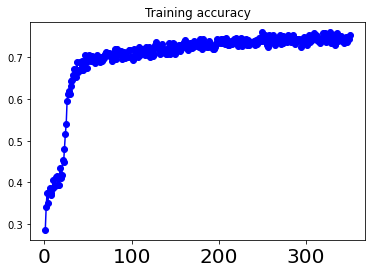

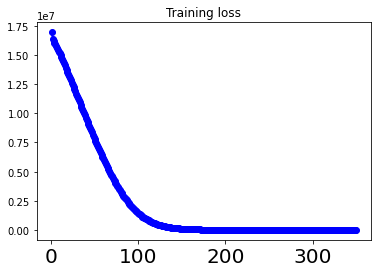

In [8]:
plf.plot_acc_loss(history)

Save the model and weights:

In [9]:
model.save('models/model_mechanism_single_gp_bnn_MT_mojavelargemlhf_5000.tf')
model.save_weights('models/model_weights_mechanism_single_gp_bnn_MT_mojavelargemlhf_5000')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/model_mechanism_single_gp_bnn_MT_mojavelargemlhf_5000.tf/assets


If you want to load the model again you can use the following functions to load the model, compile it and attach the weights:

In [5]:
model = tf.keras.models.load_model('models/model_mechanism_single_gp_bnn_MT_mojavelargemlhf_5000.tf', compile=False) 
# model compilation in seperate step because we use Tensorflow probability layers and loss
model.compile(optimizer=Adam(), 
              loss=cnn_util.loss_function_negative_log_likelihood())

# To be able to evaluate the neg-log likelihood given certaint input we also need to load the weights again
checkpoint_status = model.load_weights('models/model_weights_mechanism_single_gp_bnn_MT_mojavelargemlhf_5000')

# Test with real data
## Download data

We now download the data for an event of the 2019 Ridgecrest earthquake sequence to test our trained model on it. Download is done using the "seigerdown script". Inputs are date, time, latitude, longitude, depth, station radius, lowest frequency, downsampling frequency and the name of the download folder.
The waveforms are downloaded and restituted.

In [11]:
# the command line for its use are applied here in this system command: 
os.system("python3 seigerdown.py 2019-07-11 23:45:18.680 35.9501667 117.7031667 4.32 150 0.05 20 ev_1 --force")
# For convience we combine all traces into one mseed file
os.system("cat data/events/ev_1/waveforms/rest/*.mseed > data/events/ev_1/waveforms/rest/traces.mseed")


0

## Reference mechanism

The moment tensor from SCEDC for this downloaded earthquake can be found here: 
https://service.scedc.caltech.edu/MomentTensor/solutions/web_38538991/ci38538991_MT.html
In the following lines the information from the above website is hardcoded into a reference moment tensor, so we can compare our predicted moment tensor with this indepently determined moment tensor. We plot this refrence mechanism.

Scalar Moment [Nm]: M0 = 1.97319e+19 (Mw = 6.8)
Moment Tensor [Nm]: Mnn = -0.090,  Mee =  0.100, Mdd = -0.010,
                    Mne = -0.160,  Mnd =  0.062, Med =  0.022    [ x 1e+20 ]
Fault plane 1 [deg]: strike = 253, dip =  79, slip-rake =  -16
Fault plane 2 [deg]: strike = 346, dip =  74, slip-rake = -169



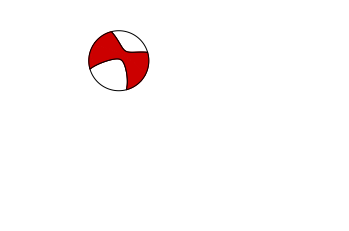

In [6]:
Mxx=-8.999e+21
Mxy=-1.598e+22
Mxz=6.197e+21
Myy=9.964e+21
Myz=2.233e+21
Mzz=-9.657e+20
d2n = 0.001
M = [Mxx, Myy, Mzz, Mxy, Mxz, Myz]
mt_reference = pmt.MomentTensor(mnn=M[0]*d2n, mee=M[1]*d2n, mdd=M[2]*d2n, mne=M[3]*d2n, mnd=M[4]*d2n, med=M[5]*d2n)
print(mt_reference)
plf.plot_pred_mt([mt_reference])


## Predict the mechanism given the downloaded data
The estimated source mechanism is not exactly the same as the reference source mechanism but differs mostly in the estimated strike. This is because of the coarse discretization and resulting small number of synthetic waveforms on which learning was performed. 

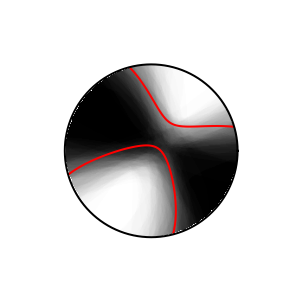

In [8]:
data_dir="data/events/"

# Retrieve the downloaded waveforms
store = engine.get_store(store_id)
waveforms_events, nsamples, events, waveforms_shifted = wp.load_data(data_dir, store_id, engine=engine)
data_events, nsamples = wp.prepare_waveforms(waveforms_events)
data_events = cnn_util.convert_data_events_to_input(data_events)

# Make 100 predictions using the same input, we see that there is a little deviation in the output prediction using the same input
preds = []
for i in range(100):
    try:
        pred = model(data_events)
        pred_mt, pred_values = cnn_util.convert_norm2real([pred])
        preds.append(pred_mt[0])
 

    except:
        pass
# Plot the ensemble as a fuzzy beachball and the reference mechanism with red lines
plf.plot_pred_bayesian_mt(preds, best_mt=mt_reference)


We now plot the layer activations given our downloaded waveform input. For plotting the activation we use keract. Notice that one station we trained for has no data available for this earthquake, therefore all its values are set to 0.

Activation (1, 123, 49, 1) 


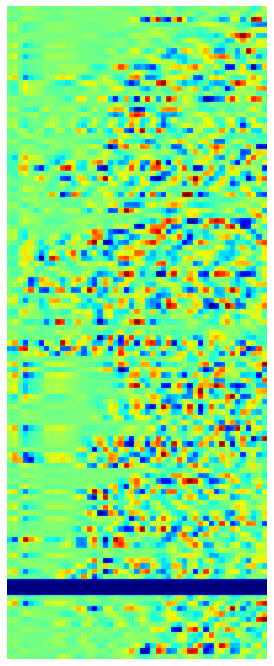

TimeConv0 (1, 123, 48, 8) 
[-0.04158387  0.10605398  0.25369182]
[0.  0.5 1. ]
0.0 1.0
[-0.11298716  0.40863281  0.93025279]
[0.  0.5 1. ]
0.0 1.0
[-0.07463406  0.23685683  0.54834771]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[-0.07793081  0.11561184  0.30915448]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[-0.05488778  0.11680334  0.28849447]
[0.  0.5 1. ]
0.0 1.0


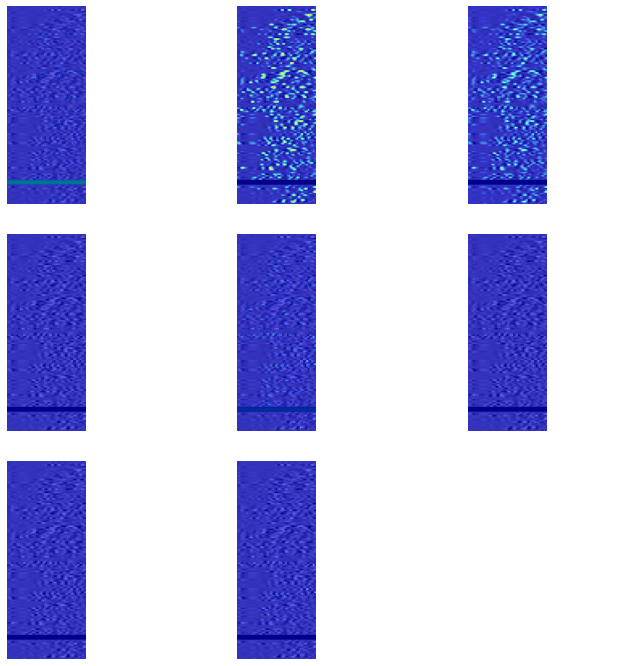

Dropout0 (1, 123, 48, 8) 
[-0.04158387  0.10605398  0.25369182]
[0.  0.5 1. ]
0.0 1.0
[-0.11298716  0.40863281  0.93025279]
[0.  0.5 1. ]
0.0 1.0
[-0.07463406  0.23685683  0.54834771]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[-0.07793081  0.11561184  0.30915448]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[-0.05488778  0.11680334  0.28849447]
[0.  0.5 1. ]
0.0 1.0


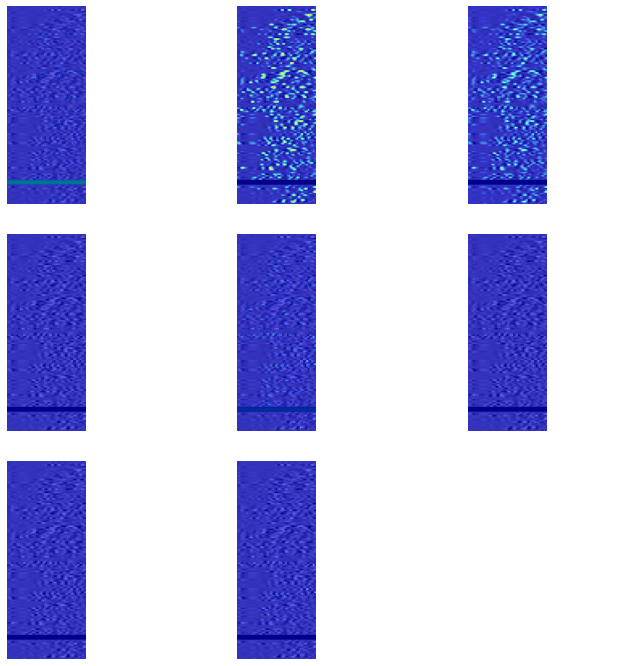

TimeConv1 (1, 123, 19, 10) 
[-0.09083025  0.50679705  1.10442436]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0


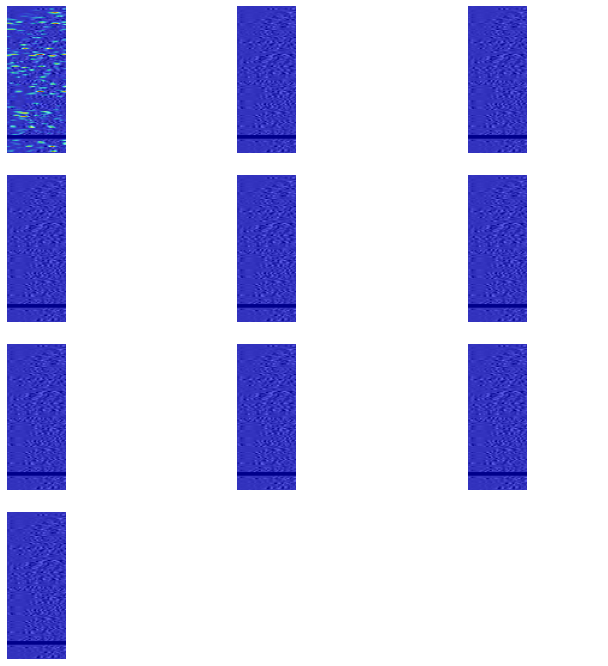

Dropout1 (1, 123, 19, 10) 
[-0.09083025  0.50679705  1.10442436]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0


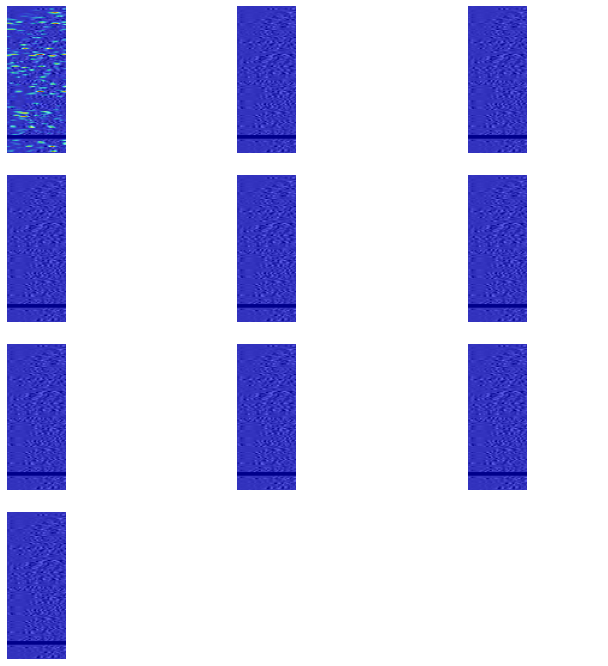

StationConv (1, 121, 19, 12) 
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[-0.20721242  0.38954948  0.98631138]
[0.  0.5 1. ]
0.0 1.0
[-0.09504765  0.38817495  0.87139755]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[-0.1521282   0.36947975  0.89108771]
[0.  0.5 1. ]
0.0 1.0


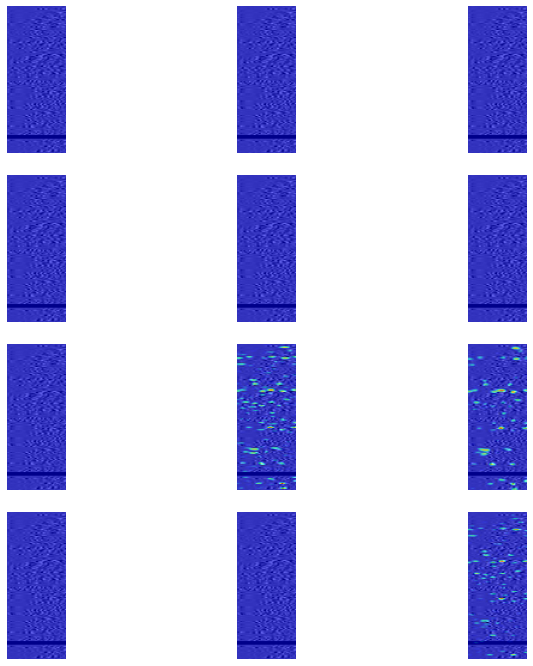

Dropout2 (1, 121, 19, 12) 
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[-0.20721242  0.38954948  0.98631138]
[0.  0.5 1. ]
0.0 1.0
[-0.09504765  0.38817495  0.87139755]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[-0.1521282   0.36947975  0.89108771]
[0.  0.5 1. ]
0.0 1.0


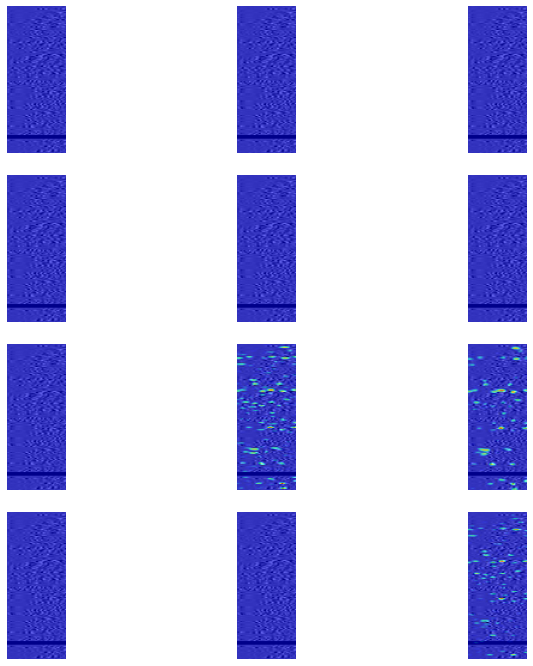

Pooling (1, 30, 5, 12) 
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[-0.23277283  0.38938683  1.01154649]
[0.  0.5 1. ]
0.0 1.0
[-0.27662677  0.29677832  0.87018341]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[0. 0. 0.]
[0.  0.5 1. ]
0.0 1.0
[-0.22882937  0.33167929  0.89218795]
[0.  0.5 1. ]
0.0 1.0


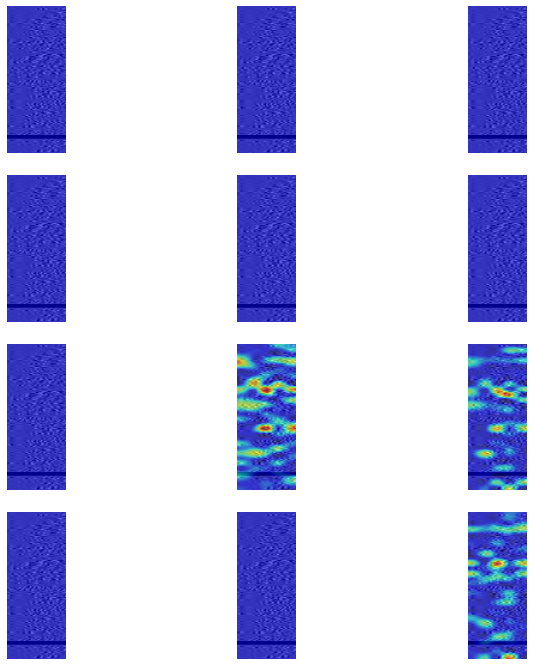

DenseFlipout (1, 3600) -> Skipped. 2D Activations.


In [9]:
import keract

# Getting all the activations using keract
activations = keract.get_activations(model, data_events, layer_names=["Activation", "TimeConv0", "Dropout0", "TimeConv1", "Dropout1", "StationConv", "Dropout2", "Pooling", "DenseFlipout"])
# Plotting using keract
keract.display_heatmaps(activations, data_events) # to save the files use: save=True, directory='pics' 

## Predict under consideration of error in timing


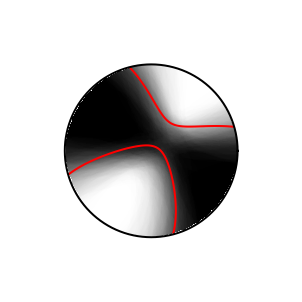

In [10]:
data_dir="data/events/"

waveforms_evs, nsamples, events, waveforms_shifted = wp.load_data(data_dir, store_id, engine=engine, error_t=0.001)
preds = []
for waveforms in waveforms_shifted[0]:
    data_events = cnn_util.convert_waveforms_to_input(waveforms)
    for i in range(100):
        pred = model.predict(data_events)
        pred_mt, pred_values = cnn_util.convert_norm2real([pred])
        preds.append(pred_mt[0])
        # loss = model.evaluate(data_events, verbose=0)
plf.plot_pred_bayesian_mt(preds, best_mt=mt_reference)


## Predict under consideration of error in timing, location and velocity model
We now also predict the source mechanism given an uncertainity in depth and for two different velocity models.


### Warning!
The following cell are only for demonstration purposes on how multiple models can be trained. The cell does not need to be evaluated, as the resulting models are already stored in the folder models. We do not recommend running this code in a jupyter notebook.

In [ ]:
# Generate all the waveforms
store_ids = ["mojavelargemlhf", "cosoml"]
depths = [5000, 7000]
coordinates = [lats, lons, depths]
for store_id in store_ids:
    waveforms_events = wp.generate_test_data_grid(store_id, store_dirs, coordinates, geometry_params, batch_loading=41)

# Simple, unparallel loop 
for lat in coordinates[0]:
    for lon in coordinates[1]:
        for depth in coordinates[2]:
            model = get_model()
            history = model.fit_generator(generator=training_batch_generator,
                               steps_per_epoch = 40,
                              verbose=1,
                               epochs = 300)
        model.save('models/model_mechanism_single_gp_bnn_MT_mojave_5000.tf')
        model.save_weights('models/model_weights_mechanism_single_gp_bnn_MT_mojave_5000')
        paths = []
        pathlist = Path('grids/grid_%s_%s_%s_%s' %(store_id, lat, lon, depth)).glob('*')
        for path in sorted(pathlist):
            try:
                f = open(path, 'rb')
                data_events, labels_events, nsamples, events = pickle.load(f)
                f.close()
                paths.append(path)
            except:
                pass


### Prediction of ensemble of source parameters


In [16]:
depths = [5000]
data_dir="data/events/"

coordinates = [lats, lons, depths]
preds = []
losses = []
store_ids = ["mojavelargemlhf", "cosoml"]  # make predictions based on two different GF stores
for store_id in store_ids:
        for depth in coordinates[2]:
            model = tf.keras.models.load_model('models/model_mechanism_single_gp_bnn_MT_%s_%s.tf' % (store_id, depth), compile=False) 
            model.compile(optimizer=Adam(), 
                          loss=cnn_util.loss_function_negative_log_likelihood())
            model.load_weights('models/model_weights_mechanism_single_gp_bnn_MT_%s_%s' % (store_id, depth))
            waveforms_evs, nsamples, events, waveforms_shifted = wp.load_data(data_dir, store_id, engine=engine, error_t=0.3)
            for waveforms in waveforms_shifted[0]:

                waveforms_events = [waveforms[:]]
                data_events, nsamples = wp.prepare_waveforms(waveforms_events)
                data_events = np.asarray(data_events)
                data_events = data_events.reshape((data_events.shape[0],)+data_events.shape[1:]+(1,))
                data_events = np.float32(data_events)
                for i in range(100):  # predict 100 times from the same input
                    try:
                        pred = model.predict(data_events)
                        pred_mt, pred_values = cnn_util.convert_norm2real([pred])
                        preds.append(pred_mt[0])
                        loss = model.evaluate(data_events)
                        losses.append(loss)
                        tf.keras.backend.clear_session()
                    except:
                        pass

1/1 [==============================] - 0s 855us/step - loss: 3726.0654


1/1 [==============================] - 0s 926us/step - loss: 3556.8237


1/1 [==============================] - 0s 1ms/step - loss: 3556.8237


1/1 [==============================] - 0s 1ms/step - loss: 3556.8237


Lets plot the ensemble of source parameters and outline the model with lowest loss (neg-log likliehood).

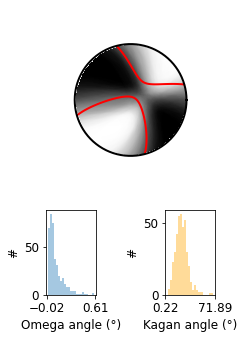

In [17]:
min_loss = min(losses)
min_loss_index = losses.index(min_loss)

fig = plf.plot_pred_bayesian_mt_hist(preds, best_mt=mt_reference, hist=True)